In [16]:
import os
import re

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cv2.data import haarcascades
from keras.models import load_model
from tqdm import tqdm

In [3]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [2]:
print("Loading model FaceQnet_v1 for scoring faces ...")
model = load_model(os.path.join("models", "FaceQnet_v1.h5"))
print("Model loaded!")

Loading model FaceQnet_v1 for scoring faces ...
Model loaded!


The Face Detection scripts will look for the following FaceForensics++ directories:
- Dataset
    - Frames
        - fake
            - Face2Face
            - Deepfakes
            - Faceswap
        - real

Inside each "fake" folder (Face2Face, Deepfakes and Faceswap), you should have:
- 000_003-frame0.jpg
- 000_003-frame1.jpg
- ...
- 999_960-frame285.jpg

Inside the "real" folder, you should have:
- 000-frame0.jpg
- 000-frame1.jpg
- ...
- 999-frame285.jpg

=============================================================================

For the output, the directories should be the following:
- Output/
    - fake/
        - Face2Face/
            - frames_cropped/
        - Deepfakes/
            - frames_cropped/
        - Faceswap
            - frames_cropped/
    - real/
        - frames_cropped/

For this purpose, when you run the script (e.g. for Face2Face), the algorithm will automatically create these directories if they do not exist.

# CV2 | Haar Cascade method

## Multiple images (Main algorithm)

In [ ]:
output_size = (384, 384)
checkpoint = None # Example: '337-frame72.jpg' (Real) or '056_996-frame258.jpg' (Fake)

path = os.path.join("Dataset", "Frames", "fake","Face2Face")
output = os.path.join("Output", "fake", "Face2Face", "frames_cropped")

if not (os.path.exists(output)):
    os.makedirs(output)
    
face_cascade = cv2.CascadeClassifier(haarcascades +'haarcascade_frontalface_alt.xml')

with open('multiple_faces_fake_face2face.txt', 'a') as file:

    print("Sorting files ...")
    listPictures = sorted_alphanumeric(os.listdir(path))
    if checkpoint is not None:
        listPictures = listPictures[listPictures.index(checkpoint):]
    print("Sort done! Starting detection... ")

    # Loop over the images
    for image_file in tqdm(listPictures):
        i = 0
        face_list = []
        dim_face_list = []

        # Load image
        img = (cv2.imread(os.path.join(path, image_file), cv2.IMREAD_COLOR))[:, :, ::-1]
        
        # read the haarcascade to detect the faces in an image
        faces = face_cascade.detectMultiScale(img, 1.1, 4)

        # Loop over all detected faces
        if len(faces) == 1:
            for i, (x, y, w, h) in enumerate(faces):
                # To draw a rectangle in a face
                face = img[y:y+h, x:x+w]
        elif len(faces) > 1:
            file.write(image_file + '\n')
            
            for i, (x,y,w,h) in enumerate(faces):
                face = img[y:y+h, x:x+w]
                face_list.append(face)
                height, width, channel = face.shape
                
                resized_face = np.array(cv2.resize(face, (224, 224)), copy=False, dtype=np.float32)
                score = model.predict(np.reshape(resized_face, (1, 224, 224, 3)), batch_size=1, verbose=0)
                
                # Takes only the height because the image are nxn
                dim_face_list.append([height, score, face])

            max_height_index = max(range(len(dim_face_list)), key=lambda i: dim_face_list[i][0])
            max_score_index = max(range(len(dim_face_list)), key=lambda i: dim_face_list[i][1])

            if max_height_index == max_score_index:
                max_row = dim_face_list[max_height_index]
            else:
                max_row = max(dim_face_list, key=lambda row: row[0])

            face = max_row[2]

        else:
            file.write(image_file + ' | No face detected\n')
            continue

        cv2.imwrite(os.path.join(output, image_file), cv2.resize(face[:, :, ::-1], output_size))

## Single image
(For fixing a single image only)<br>

In order to try and recognize faces which had not been recognized before, play with the "precisionMultiscale" parameter.<br>
Setting precisionMultiscale = 0, will give you more Rectangle boxes, so it goes into the detail of the image.<br>
Setting precisionMultiscale = 1, will give you fewer Rectangle boxes, since it's trying to generalize.<br>
By looking at scores and shapes of the various rectangles, you could infer which one is the correct one.<br>
Then, either put the corresponding score (4) or rectangle shape (3) and re-run the script.<br>

In the example, I found the right rectangle by applying formula 3 and looking for the rectangle of shape 122x122.<br>

<i>The default formula is that it retrieves the rectangle with best facial score.</i>

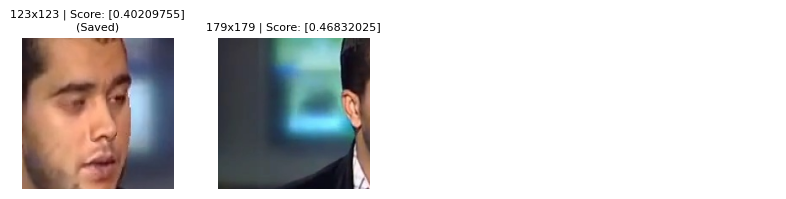

In [ ]:
image = '' # Example: '337-frame72.jpg' (Real) or '056_996-frame258.jpg' (Fake)
precisionMultiscale = 1

path = os.path.join("Dataset", "Frames", "fake", "Face2Face", image)
output = os.path.join("Output", "fake", "Face2Face", "frames_cropped")

if not (os.path.exists(output)):
    os.makedirs(output)

output_size = (384, 384)

face_cascade = cv2.CascadeClassifier(haarcascades +'haarcascade_frontalface_alt.xml')               
                
scores = []
face = None
multipleFaces = False

# Load image
img = (cv2.imread(os.path.join(path), cv2.IMREAD_COLOR))

if img is None:
    print(F"No image found at '{image}'. Check your path")
else:
    # Read the haarcascade to detect the faces in an image
    faces = face_cascade.detectMultiScale(img, 1.1, precisionMultiscale)

    if len(faces) < 1:
        print('No face detected for this image.')
    elif len(faces) == 1:
        for i, (x, y, w, h) in enumerate(faces):
            # To draw a rectangle in a face
            face = img[y:y+h, x:x+w]
    else:
        multipleFaces = True
        for i, (x, y, w, h) in enumerate(faces):
            face = img[y:y+h, x:x+w]

            resized_face = np.array(cv2.resize(face, (224, 224)), copy=False, dtype=np.float32)
            score = model.predict(np.reshape(resized_face, (1, 224, 224, 3)), batch_size=1, verbose=0)
            scores.append([score, face, face.shape[0]])

        scores = sorted(scores, key=lambda x: x[2])
        print(F"Possible values for rectangles are: {[rect[2] for rect in scores]}")

        face = max(scores, key=lambda x: x[0])                  # -> If we want to choose over the best score. (1)
        #face = max(scores, key=lambda x: x[2])                 # -> If we want to choose over the largest rectangle. (2)
        #face = [x for x in scores if x[2] == 122][0]            # -> If we want to choose over a particular shape of a rectangle. (3)
        #face = [x for x in scores if x[0] == 0.2068924][0]    # -> If we want to choose over a particular score. (4)
        
        score = float(face[0][0])
        face = face[1]

    if face is not None:

        if len(faces) > 1:
            # Create a grid of subplots
            num_plots = len(scores)
            num_cols = 4  # Number of columns in the grid
            num_rows = (num_plots - 1) // num_cols + 1
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 2*num_rows))
            axes = axes.flatten()  # Flatten the axes array to simplify indexing

            # Iterate over scores and plot images in subplots
            for i, (score, img, shape) in enumerate(scores):
                ax = axes[i]  # Select the appropriate subplot
                ax.imshow(img[:, :, ::-1])  # Plot the image
                if(img is not face):
                    ax.set_title(F"{str(shape)}x{str(shape)} | Score: {str(score[0])}", fontdict={'fontsize': 8})
                else:
                    ax.set_title(F"{str(shape)}x{str(shape)} | Score: {str(score[0])}\n(Saved)", fontdict={'fontsize': 8})
                ax.axis('off')  # Turn off axis labels

            # Hide any remaining empty subplots
            for j in range(i + 1, num_rows * num_cols):
                axes[j].axis('off')

            plt.tight_layout()  # Adjust spacing between subplots
            plt.show()
        else:
            plt.title(F"Image: {image}\nShape: {face.shape}")
            plt.imshow(face[:, :, ::-1])
        cv2.imwrite(os.path.join(output, image), cv2.resize(face, output_size))

# Reorder the log file about multiple faces

In [15]:
# Use real_images = True if you are working with images from the "Real" class.
# Use real_images = False if you are working with images from the "Fake" class.
real_images = False
path = ''   # Example: 'multiple_faces_fake_face2face.txt'
output = '' # Example: 'final_fake_face2face.txt'

# Read the file into a pandas dataframe
df = pd.read_csv(path, header=None, names=['string'])

if(real_images):
    # Extract the video and frame numbers into separate columns
    df[['video', 'frame']] = df['string'].str.extract(r'(\d+)-frame(\d+)\.jpg')
else:
     # Extract the video and frame numbers into separate columns
    df[['video', 'fakeVideo', 'frame']] = df['string'].str.extract(r'(\d+)_(\d+)-frame(\d+)\.jpg')

# Convert the video and frame columns to integers
df['video'] = df['video'].astype(str)
df['frame'] = df['frame'].astype(str)

# Group the data by 'video'
grouped = df.groupby('video')

# Create a list to store the lines for the output file
lines = []
i = 0

# Iterate over each group
for video, group in grouped:
    frames = []

    if not real_images:
        video = video.split("_")[0]
        
    lines.append(f'Video: {video} (Possible multiple faces)')

    # Check if any frames have "No face detected" message
    no_face_frames = group[group['string'].str.contains('No face detected')]

    # Add lines for frames with "No face detected"
    if not no_face_frames.empty:
        for _, row in no_face_frames.iterrows():
            frames.append(str(row['frame']))
            i += 1

        result = '-'.join(frames)
        lines.append(f'Video: {video} | No face detected at frame {result}.')

    lines.append("======================================")

# Write the lines to the output file
with open(output, 'w') as f:
    f.write('\n'.join(lines))

print(F"No faces detected for {i} frames.")

No faces detected for 428 frames.
